## Environment

In [13]:
class GridWorld():
    def __init__(self):
        self.x=0
        self.y=0

    def step(self,a):
        if a==0:
            self.move_left()
        elif a==1:
            self.move_up()
        elif a==2:
            self.move_right()
        elif a==3:
            self.move_down()
        reward = -1 # 보상은 항상 -1로 구정
        done = self.is_done()
        return (self.x,self.y),reward,done
    
    def move_left(self):
        if self.y==0:
            pass
        elif self.y==3 and self.x in [0,1,2]:
            pass
        elif self.y==5 and self.x in [2,3,4]:
            pass
        else:
            self.y-=1

    def move_right(self):
        if self.y==1 and self.x in [0,1,2]:
            pass
        elif self.y==3 and self.x in [2,3,4]:
            pass
        elif self.y==6:
            pass
        else:
            self.y+=1

    def move_up(self):
        if self.x==0:
            pass
        elif self.x==3 and self.y==2:
            pass
        else:
            self.x-=1

    def move_down(self):
        if self.x==4:
            pass
        elif self.x==1 and self.y==4:
            pass
        else:
            self.x+=1

    def is_done(self):
        if self.x==4 and self.y==6: # 목표 지점에 도달하면 끝
            return True
        else:
            return False
        
    def reset(self):
        self.x=0
        self.y=0
        return (self.x,self.y)

In [14]:
import random
import numpy as np
from utils.visualization import action_visualize

# 방법1. MCControl

## Agent

In [15]:
class Agent():
    def __init__(self):
        self.q_table=np.zeros((5,7,4)) # q-value를 저장하는 변수, 모두 0으로 초기화
        self.eps=0.9 # 랜덤 행동을 할 확률
        self.gamma=1.0
        self.alpha=0.01 # learning rate

    def select_action(self,s):
        # eps-greedy로 액션을 선택
        x,y=s
        coin=random.random()
        if coin<self.eps:
            action=random.randint(0,3)
        else:
            action_val=self.q_table[x,y,:]
            action=np.argmax(action_val)
        return action
    
    def update_table(self,history):
        # 한 에피소드에 해당하는 history를 입력으로 받아 q-table을 업데이트
        cum_reward=0
        for transition in history[::-1]:
            s,a,r,s_prime=transition
            x,y=s
            # 몬테카를로 방식
            self.q_table[x,y,a] = self.q_table[x,y,a]+self.alpha*(cum_reward-self.q_table[x,y,a])
            cum_reward= self.gamma*cum_reward+r
    
    def anneal_eps(self):
        self.eps-=0.03
        self.eps=max(self.eps,0.1)

    def show_table(self):
        q_lst=self.q_table.tolist()
        data = np.zeros((5,7))
        for row_idx in range(len(q_lst)):
            row = q_lst[row_idx]
            for col_idx in range(len(row)):
                col = row[col_idx]
                action = np.argmax(col)
                data[row_idx,col_idx] = action
        return data

## 메인함수

In [16]:
def MC_main():
    env = GridWorld()
    agent = Agent()
    
    for n_epi in range(1000):
        done= False
        history= []
        
        s = env.reset()
        while not done: # 한 에피소드가 끝날 때까지
            a=agent.select_action(s)
            s_prime,r,done=env.step(a)
            history.append((s,a,r,s_prime))
            s=s_prime
        agent.update_table(history)
        agent.anneal_eps()

    return agent.show_table()

In [17]:
if __name__ == '__main__':
    MC_action = MC_main()
    print(MC_action)

[[3. 3. 0. 3. 2. 3. 3.]
 [3. 2. 0. 2. 2. 3. 3.]
 [3. 1. 0. 1. 0. 3. 0.]
 [2. 2. 2. 1. 0. 3. 3.]
 [1. 1. 2. 2. 0. 2. 0.]]


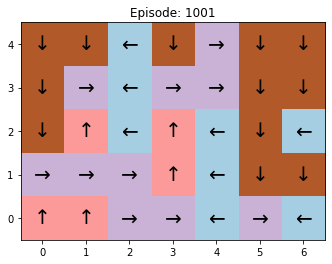

In [18]:
action_visualize(1000, MC_action)

# 방법2. TD Control - SARSA

## Agent

In [19]:
class SAgent(Agent):
    def update_table(self, transition):
        s,a,r,s_prime=transition
        x,y=s
        next_x,next_y=s_prime
        a_prime=self.select_action(s_prime)
        self.q_table[x,y,a]=self.q_table[x,y,a]+self.alpha*(r+self.q_table[next_x,next_y,a_prime]-self.q_table[x,y,a])

## 메인함수

In [21]:
def TD_main():
    env=GridWorld()
    agent=SAgent()
    
    for n_epi in range(1000):
        done=False
        s=env.reset()
        while not done:
            a=agent.select_action(s)
            s_prime,r,done=env.step(a)
            agent.update_table((s,a,r,s_prime))
            s=s_prime
        agent.anneal_eps()
    return agent.show_table()

In [22]:
if __name__ == '__main__':
    S_action = TD_main()
    print(S_action)

[[3. 1. 0. 1. 1. 3. 1.]
 [0. 1. 0. 2. 2. 3. 3.]
 [3. 2. 0. 1. 0. 3. 3.]
 [1. 2. 3. 1. 0. 3. 3.]
 [0. 0. 2. 1. 0. 2. 0.]]


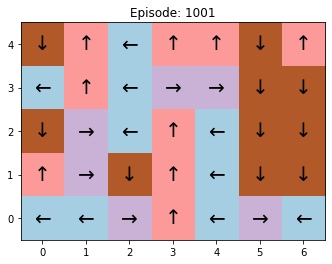

In [24]:
action_visualize(1000, S_action)

# 방법3. TD Control - Q-Learning

## Agent

In [25]:
class QAgent(Agent):
    def update_table(self, transition):
        s,a,r,s_prime=transition
        x,y=s
        next_x,next_y=s_prime
        self.q_table[x,y,a]=self.q_table[x,y,a]+self.alpha*(r+np.amax(self.q_table[next_x,next_y,:])-self.q_table[x,y,a])
    
    def anneal_eps(self):
        self.eps-=0.01
        self.eps=max(self.eps,0.2)

## 메인함수

In [26]:
def TD_main():
    env=GridWorld()
    agent=QAgent()
    
    for n_epi in range(1000):
        done=False
        s=env.reset()
        while not done:
            a=agent.select_action(s)
            s_prime,r,done=env.step(a)
            agent.update_table((s,a,r,s_prime))
            s=s_prime
        agent.anneal_eps()
    return agent.show_table()

In [27]:
if __name__ == '__main__':
    Q_action = TD_main()
    print(Q_action)

[[3. 2. 0. 0. 1. 1. 1.]
 [3. 2. 0. 2. 1. 3. 2.]
 [2. 1. 0. 1. 0. 3. 3.]
 [1. 3. 0. 3. 0. 3. 3.]
 [1. 2. 3. 0. 0. 3. 0.]]


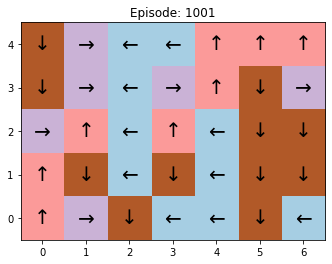

In [28]:
action_visualize(1000, Q_action)